In [15]:
import numpy as np
import pandas as pd
import matplotlib
matplotlib.use('Agg') 
import matplotlib.pyplot as plt
import sys
from pathlib import Path
from typing import Dict, List, Tuple
from ase.io import read
from ase.geometry import get_distances
import warnings

try:
    import natsort
except ImportError:
    natsort = None

warnings.filterwarnings('ignore')

# ========================================================================
# 設定パラメータ
# ========================================================================

# TARGET_DIR = "/home/jovyan/Kaori/MD/LiB_2/structure/MD_LiF_Al_thin3/heat"
TARGET_DIR = "/home/jovyan/Kaori/MD/LiB_2/structure/Al_LiOH_v4"
FILE_EXTENSION = "*.traj" 
OUTPUT_DIR_NAME = "/home/jovyan/Kaori/MD/LiB_2/structure/Al_LiOH_v4/output_Al_Oxide" 

# 解析パラメータ
ANALYSIS_PARAMS = {
    'HF_cutoff': 1.1,
    'AlF_cutoff': 2.0,
    'OH_cutoff': 1.1,   
    'HH_cutoff': 0.9,
    'PF_cutoff': 1.8,
    'LiF_cutoff': 2.0,
    'AlO_cutoff': 2.2,
    
    'frame_interval': 10,
    # 時間単位の設定: 1フレームあたりの時間(fs)
    # 例: 1step=1.0fsで100step毎に保存なら 100.0 に設定してください
    'dt_fs': 100.0, 
    
    'rdf_rmax': 6.0,
    'rdf_bins': 100,
    'rdf_start_ratio': 0.5,
}

# ========================================================================
# 関数群
# ========================================================================

def generate_output_filename_prefix(path_str):
    return Path(path_str).stem

def get_traj_files(target_directory, recursive=False):
    p = Path(target_directory)
    if not p.exists(): return []
    pattern = FILE_EXTENSION
    files = list(p.rglob(pattern)) if recursive else list(p.glob(pattern))
    file_paths = [str(f) for f in files]
    if natsort:
        return natsort.natsorted(file_paths)
    else:
        return sorted(file_paths)

def compute_rdf_frame(atoms, elem1, elem2, rmax, nbins):
    idx1 = [a.index for a in atoms if a.symbol == elem1]
    idx2 = [a.index for a in atoms if a.symbol == elem2]
    if len(idx1) == 0 or len(idx2) == 0: return np.zeros(nbins), np.zeros(nbins)
    
    if elem1 == elem2:
        dists = get_distances(atoms.positions[idx1], atoms.positions[idx2], cell=atoms.cell, pbc=atoms.pbc)[1]
        valid_dists = dists[dists > 0.01] 
    else:
        dists = get_distances(atoms.positions[idx1], atoms.positions[idx2], cell=atoms.cell, pbc=atoms.pbc)[1]
        valid_dists = dists.flatten()

    hist, bin_edges = np.histogram(valid_dists, range=(0, rmax), bins=nbins)
    return hist, bin_edges

# ========================================================================
# 【改良版】分子・結合識別関数
# ========================================================================
def identify_molecules(atoms, params: Dict) -> Dict[str, float]:
    # カウンタの初期化
    counts = {
        'H2O_sol': 0,       # 溶液中の水 (Alに結合していない)
        'Al_H2O_ads': 0,    # Alに吸着した水 (H=2, Al結合あり)
        'Al_OH_groups': 0,  # Alに結合したOH基 (H=1, Al結合あり)
        'Free_OH': 0,       # 溶液中のOHイオン
        
        'Al_O_bonds': 0,    # Al-O結合のペア総数 (距離のみで判定)
        
        'HF': 0,
        'H2': 0,
        'Al_F_bonds': 0,
        'LiF': 0, 
        'PF6_anion': 0, 'PF5': 0, 'PF_broken': 0,
    }
    
    positions = atoms.positions
    symbols = np.array(atoms.get_chemical_symbols)

    H_idx = np.where(symbols == 'H')[0]
    F_idx = np.where(symbols == 'F')[0]
    O_idx = np.where(symbols == 'O')[0]
    Al_idx = np.where(symbols == 'Al')[0]
    Li_idx = np.where(symbols == 'Li')[0]
    P_idx = np.where(symbols == 'P')[0]

    # --- 1. 酸素原子の状態分類 (H2O vs OH vs O) ---
    # o_h_counts[i] : i番目のO原子に結合しているHの数
    o_h_counts = np.zeros(len(O_idx), dtype=int)
    
    if len(O_idx) > 0 and len(H_idx) > 0:
        o_pos = positions[O_idx]
        h_pos = positions[H_idx]
        # O-H 距離計算 (N_O x N_H)
        oh_dists = get_distances(o_pos, h_pos, cell=atoms.cell, pbc=atoms.pbc)[1]
        
        for i in range(len(O_idx)):
            # カットオフ以内のHの数をカウント
            o_h_counts[i] = (oh_dists[i] < params['OH_cutoff']).sum()

    # --- 2. 酸素原子とAlとの結合判定 ---
    # o_al_bonded[i] : i番目のO原子がAlと結合しているか (True/False)
    o_al_bonded = np.zeros(len(O_idx), dtype=bool)
    
    if len(O_idx) > 0 and len(Al_idx) > 0:
        al_pos = positions[Al_idx]
        o_pos = positions[O_idx]
        # Al-O 距離計算 (N_Al x N_O)
        alo_dists = get_distances(al_pos, o_pos, cell=atoms.cell, pbc=atoms.pbc)[1]
        
        # Al-O結合ペア総数 (単純な距離判定の総和)
        counts['Al_O_bonds'] = (alo_dists < params['AlO_cutoff']).sum()
        
        # 各O原子について、いずれかのAlと結合しているかチェック
        # axis=0 (Al方向) にanyを取る -> サイズ(N_O,)の配列
        o_al_bonded = (alo_dists < params['AlO_cutoff']).any(axis=0)

    # --- 3. 集計 (重複なし分類) ---
    for i in range(len(O_idx)):
        num_h = o_h_counts[i]
        is_on_al = o_al_bonded[i]
        
        if num_h == 2: # 水分子 (H2O)
            if is_on_al:
                counts['Al_H2O_ads'] += 1 # 吸着水
            else:
                counts['H2O_sol'] += 1    # 溶媒水
        
        elif num_h == 1: # OH基
            if is_on_al:
                counts['Al_OH_groups'] += 1 # 表面水酸基
            else:
                counts['Free_OH'] += 1      # 溶解OH
        
        # num_h == 0 は酸化物イオン (Al2O3など) -> カウントしない

    # --- その他 (HF, LiF, Al-F) ---
    # HF
    if len(H_idx) > 0 and len(F_idx) > 0:
        dists = get_distances(positions[H_idx], positions[F_idx], cell=atoms.cell, pbc=atoms.pbc)[1]
        counts['HF'] = (dists < params['HF_cutoff']).sum()

    # Al-F
    if len(Al_idx) > 0 and len(F_idx) > 0:
        dists = get_distances(positions[Al_idx], positions[F_idx], cell=atoms.cell, pbc=atoms.pbc)[1]
        counts['Al_F_bonds'] = (dists < params['AlF_cutoff']).sum()

    # LiF
    if len(Li_idx) > 0 and len(F_idx) > 0:
        dists = get_distances(positions[Li_idx], positions[F_idx], cell=atoms.cell, pbc=atoms.pbc)[1]
        counts['LiF'] = (dists < params['LiF_cutoff']).sum()
        
    return counts

# ========================================================================
# 解析メインループ
# ========================================================================
def analyze_trajectory(traj_path: str, params: Dict):
    print(f"=== 解析開始: {traj_path} ===")
    try:
        traj = read(traj_path, ":")
        if len(traj) == 0: return pd.DataFrame(), {}, {}
    except Exception as e:
        print(f"✗ 読込エラー: {e}")
        return pd.DataFrame(), {}, {}

    results = []
    rdf_data = {'Al-F': np.zeros(params['rdf_bins']), 'Al-O': np.zeros(params['rdf_bins'])}
    rdf_count = 0
    bin_edges = None
    
    frame_interval = params['frame_interval']
    dt_fs = params.get('dt_fs', 1.0)
    subset = traj[::frame_interval]
    total_frames = len(subset)
    start_rdf_idx = int(total_frames * (1.0 - params['rdf_start_ratio']))

    for i, atoms in enumerate(subset):
        frame_num = i * frame_interval
        # 時間単位変換: fs -> ps (/1000)
        current_time_ps = frame_num * dt_fs / 1000 

        molecules = identify_molecules(atoms, params)
        
        # 貫通深さ
        f_pen = 0.0
        syms = np.array(atoms.get_chemical_symbols)
        if 'Al' in syms and 'F' in syms:
            al_pos = atoms.positions[np.where(syms == 'Al')[0]]
            f_pos = atoms.positions[np.where(syms == 'F')[0]]
            al_surf_z = al_pos[:, 2].max()
            mask = f_pos[:, 2] < al_surf_z
            if mask.any(): f_pen = al_surf_z - f_pos[mask, 2].min()

        res = {'time_ps': current_time_ps, 'F_penetration_A': f_pen, 
               'temperature_K': atoms.get_temperature() if hasattr(atoms, 'get_temperature') else 0}
        for k, v in molecules.items(): res[f'n_{k}'] = v
        results.append(res)
        
        # RDF積算
        if i >= start_rdf_idx:
            h1, edges = compute_rdf_frame(atoms, 'Al', 'F', params['rdf_rmax'], params['rdf_bins'])
            rdf_data['Al-F'] += h1
            h2, _ = compute_rdf_frame(atoms, 'Al', 'O', params['rdf_rmax'], params['rdf_bins'])
            rdf_data['Al-O'] += h2
            bin_edges = edges
            rdf_count += 1

        if (i+1) % 10 == 0: print(f"\r処理中: {i+1}/{total_frames}", end="")

    print("\n✓ 解析完了")
    
    final_rdf = {}
    if rdf_count > 0 and bin_edges is not None:
        r = 0.5 * (bin_edges[1:] + bin_edges[:-1])
        dr = bin_edges[1] - bin_edges[0]
        shell_vol = 4 * np.pi * (r**2) * dr
        for pair, hist in rdf_data.items():
            final_rdf[pair] = (r, (hist / rdf_count) / shell_vol)

    return pd.DataFrame(results), final_rdf

# ========================================================================
# グラフ描画（個別ファイル用）
# ========================================================================
def plot_individual_results(df: pd.DataFrame, rdf_data: Dict, output_dir: str, file_prefix: str):
    if df.empty: return
    plt.rcParams['font.size'] = 12
    fig = plt.figure(figsize=(18, 12)) 
    gs = fig.add_gridspec(3, 3, hspace=0.4, wspace=0.3)

    # 1. Al Surface Species (修正)
    ax1 = fig.add_subplot(gs[0, 0])
    ax1.plot(df['time_ps'], df['n_Al_F_bonds'], 'b-', label='Al-F bonds')
    ax1.plot(df['time_ps'], df['n_Al_OH_groups'], 'g-', label='Al-OH groups') # 修正
    ax1.plot(df['time_ps'], df['n_Al_H2O_ads'], 'c--', label='Adsorbed H2O') # 追加
    ax1.set_title('Al Surface Species'); ax1.set_ylabel('Count'); ax1.legend(); ax1.grid(True)

    # 2. Solution H2O
    ax2 = fig.add_subplot(gs[0, 1])
    ax2.plot(df['time_ps'], df['n_H2O_sol'], 'c-')
    ax2.set_title('Free H2O in Solution'); ax2.grid(True)

    # 3. Penetration
    ax3 = fig.add_subplot(gs[0, 2])
    ax3.plot(df['time_ps'], df['F_penetration_A'], 'k-')
    ax3.set_title('F Penetration (Depth)'); ax3.grid(True)

    # 4. RDF Al-F
    ax4 = fig.add_subplot(gs[1, 0])
    if 'Al-F' in rdf_data:
        r, gr = rdf_data['Al-F']
        ax4.plot(r, gr, 'b-', label='Al-F')
        ax4.axvline(x=ANALYSIS_PARAMS['AlF_cutoff'], color='r', ls=':')
    ax4.set_title('RDF: Al-F'); ax4.grid(True)
    
    # 5. RDF Al-O
    ax5 = fig.add_subplot(gs[1, 1])
    if 'Al-O' in rdf_data:
        r, gr = rdf_data['Al-O']
        ax5.plot(r, gr, 'g-', label='Al-O')
        ax5.axvline(x=ANALYSIS_PARAMS['AlO_cutoff'], color='r', ls=':')
    ax5.set_title('RDF: Al-O'); ax5.grid(True)

    # 6. Al-O Total Bonds (検証用)
    ax6 = fig.add_subplot(gs[1, 2])
    ax6.plot(df['time_ps'], df['n_Al_O_bonds'], 'k-', alpha=0.6)
    ax6.set_title('Total Al-O Pairs (< Cutoff)'); ax6.grid(True)
    
    out_path = Path(output_dir) / f"{file_prefix}_refined.png"
    plt.savefig(out_path, dpi=100, bbox_inches='tight')
    plt.close()

# ========================================================================
# まとめグラフ
# ========================================================================
def plot_comparison_summary(summary_data: List[Dict], output_dir: str):
    if not summary_data: return
    df_sum = pd.DataFrame(summary_data)
    df_sum.sort_values('filename', inplace=True)
    labels = df_sum['filename'].values
    x = np.arange(len(labels))
    
    fig, axes = plt.subplots(2, 2, figsize=(16, 12))
    fig.suptitle('Summary Comparison (Final State)', fontsize=16)
    
    # 1. Surface Species
    ax1 = axes[0, 0]
    width = 0.25
    ax1.bar(x - width, df_sum['final_Al_F'], width, label='Al-F Bonds', color='blue')
    ax1.bar(x, df_sum['final_Al_OH'], width, label='Al-OH Groups', color='green')
    ax1.bar(x + width, df_sum['final_Al_H2O'], width, label='Adsorbed H2O', color='cyan')
    ax1.set_title('Final Surface Species Count')
    ax1.set_xticks(x); ax1.set_xticklabels(labels, rotation=45, ha='right')
    ax1.legend(); ax1.grid(axis='y', linestyle='--', alpha=0.7)
    
    # 2. Penetration
    ax2 = axes[0, 1]
    ax2.bar(x, df_sum['final_penetration'], width=0.5, color='black')
    ax2.set_title('Final F Penetration Depth [Å]')
    ax2.set_xticks(x); ax2.set_xticklabels(labels, rotation=45, ha='right')
    
    # 3. LiF Residual
    ax3 = axes[1, 0]
    ax3.bar(x, df_sum['final_LiF'], width=0.5, color='purple')
    ax3.set_title('Remaining Li-F Bonds')
    ax3.set_xticks(x); ax3.set_xticklabels(labels, rotation=45, ha='right')
    
    # 4. Total Al-O Pairs
    ax4 = axes[1, 1]
    ax4.bar(x, df_sum['final_Al_O_total'], width=0.5, color='gray')
    ax4.set_title('Total Al-O Pairs (Check)')
    ax4.set_xticks(x); ax4.set_xticklabels(labels, rotation=45, ha='right')
    
    plt.tight_layout()
    plt.subplots_adjust(top=0.92, hspace=0.6)
    plt.savefig(Path(output_dir) / "comparison_summary_refined.png", dpi=150, bbox_inches='tight')
    plt.close()
    
    df_sum.to_csv(Path(output_dir) / "summary_all_files_refined.csv", index=False)

# ========================================================================
# メイン実行
# ========================================================================
def main():
    print("=== Phase 5: Refined Analysis (OH vs H2O) ===")
    out_dir = Path(OUTPUT_DIR_NAME)
    out_dir.mkdir(exist_ok=True)
    traj_list = get_traj_files(TARGET_DIR, recursive=True)
    
    if not traj_list: print("ファイルなし"); return

    summary_list = []

    for traj_path in traj_list:
        file_prefix = generate_output_filename_prefix(traj_path)
        df, rdf_data = analyze_trajectory(traj_path, ANALYSIS_PARAMS)
        
        if not df.empty:
            df.to_csv(out_dir / f"{file_prefix}_data.csv", index=False)
            plot_individual_results(df, rdf_data, str(out_dir), file_prefix)
            
            last_row = df.iloc[-1]
            summary_list.append({
                'filename': file_prefix,
                'final_time_ps': last_row['time_ps'],
                'final_Al_F': last_row['n_Al_F_bonds'],
                'final_Al_OH': last_row['n_Al_OH_groups'],
                'final_Al_H2O': last_row['n_Al_H2O_ads'],
                'final_LiF': last_row['n_LiF'],
                'final_Al_O_total': last_row['n_Al_O_bonds'],
                'final_penetration': last_row['F_penetration_A']
            })
            
    if summary_list:
        plot_comparison_summary(summary_list, str(out_dir))
        
    print("\n完了")

if __name__ == "__main__":
    main()

=== Phase 5: Refined Analysis (OH vs H2O) ===
=== 解析開始: /home/jovyan/Kaori/MD/LiB_2/structure/Al_LiOH_v4/Al_Metal_initial_opt.traj ===


ValueError: Calling nonzero on 0d arrays is not allowed. Use np.atleast_1d(scalar).nonzero() instead. If the context of this error is of the form `arr[nonzero(cond)]`, just use `arr[cond]`.

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from ase.io.trajectory import Trajectory
from ase.geometry import get_distances
from pathlib import Path
import warnings

warnings.filterwarnings('ignore')

# 全体のフォントサイズ設定
plt.rcParams.update({
    'font.size': 14, 
    'axes.labelsize': 16, 
    'xtick.labelsize': 14, 
    'ytick.labelsize': 14,
    'legend.fontsize': 12
})

# ==========================================
# 設定パラメータ
# ==========================================
ANALYSIS_PARAMS = {
    'AlO_cutoff': 2.2,
    'OH_cutoff': 1.1,
    'rdf_rmax': 6.0,
    'rdf_bins': 100,
    'rdf_start_ratio': 0.5, # 後半50%のフレームでRDFを平均化
}

# ==========================================
# RDF計算関数 (確実な手動計算版)
# ==========================================
def compute_rdf_frame(atoms, elem1, elem2, rmax, nbins):
    symbols = np.array(atoms.get_chemical_symbols())
    idx1 = np.where(symbols == elem1)[0]
    idx2 = np.where(symbols == elem2)[0]
    
    if len(idx1) == 0 or len(idx2) == 0:
        return np.zeros(nbins), np.linspace(0, rmax, nbins+1)
    
    # 距離の計算 (PBC考慮)
    # get_distancesは (dist_array) を返す
    dists = get_distances(atoms.positions[idx1], atoms.positions[idx2], 
                          cell=atoms.cell, pbc=atoms.pbc)[1]
    
    if elem1 == elem2:
        valid_dists = dists[dists > 0.01] # 自己相関を除外
    else:
        valid_dists = dists.flatten()

    hist, bin_edges = np.histogram(valid_dists, range=(0, rmax), bins=nbins)
    return hist, bin_edges

# ==========================================
# 個別ファイルの解析コア
# ==========================================
def analyze_md_results(traj_path, output_dir, label):
    print(f"Analyzing: {traj_path.name}")
    try:
        traj = Trajectory(traj_path)
    except:
        print(f"Error reading {traj_path.name}"); return

    if len(traj) == 0: return

    # 基本情報
    final_atoms = traj[-1]
    cell_diag = final_atoms.get_cell().diagonal()
    cell_z = cell_diag[2]
    symbols = np.array(final_atoms.get_chemical_symbols())
    indices = {s: np.where(symbols == s)[0] for s in ['Al', 'Li', 'O', 'H']}

    # RDF用変数の初期化
    rdf_rmax = ANALYSIS_PARAMS['rdf_rmax']
    rdf_bins = ANALYSIS_PARAMS['rdf_bins']
    rdf_sum = np.zeros(rdf_bins)
    rdf_count = 0
    start_frame = int(len(traj) * (1.0 - ANALYSIS_PARAMS['rdf_start_ratio']))
    bin_edges = None

    # 時系列データ用
    msd_list = []
    cn_list = []
    initial_al_pos = traj[0].positions[indices['Al']]

    # --- トラジェクトリ走査 ---
    for i, atoms in enumerate(traj):
        # 1. 配位数 (Al-O)
        if len(indices['Al']) > 0 and len(indices['O']) > 0:
            pos_al = atoms.positions[indices['Al']]
            pos_o = atoms.positions[indices['O']]
            diff = pos_al[:, np.newaxis, :] - pos_o[np.newaxis, :, :]
            diff -= np.round(diff / cell_diag) * cell_diag # MIC
            dist = np.linalg.norm(diff, axis=2)
            cn_list.append(np.sum(dist < ANALYSIS_PARAMS['AlO_cutoff']) / len(indices['Al']))

        # 2. MSD (Al)
        if len(indices['Al']) > 0:
            sq_dist = np.mean(np.sum((atoms.positions[indices['Al']] - initial_al_pos)**2, axis=1))
            msd_list.append(sq_dist)

        # 3. RDF積算 (後半フレームのみ)
        if i >= start_frame:
            hist, edges = compute_rdf_frame(atoms, 'Al', 'O', rdf_rmax, rdf_bins)
            rdf_sum += hist
            bin_edges = edges
            rdf_count += 1

    # ==========================================
    # グラフ作成セクション
    # ==========================================
    
    # 1. 密度プロファイル
    plt.figure(figsize=(8, 5))
    bins = np.linspace(0, cell_z, 100)
    for spec, idx in indices.items():
        if len(idx) > 0:
            plt.hist(final_atoms.positions[idx, 2], bins=bins, histtype='step', label=spec, linewidth=2)
    plt.title(f"Density Profile: {label}"); plt.xlabel("Z position (Å)"); plt.ylabel("Count"); plt.legend()
    plt.tight_layout(); plt.savefig(output_dir / f"{label}_density.png"); plt.close()

    # 2. RDF (Al-O) の正規化と描画
    if rdf_count > 0 and bin_edges is not None:
        r = 0.5 * (bin_edges[1:] + bin_edges[:-1])
        dr = bin_edges[1] - bin_edges[0]
        # 体積正規化 (g(r)の計算)
        # 密度rho = (対象原子数) / セル体積
        n_o = len(indices['O'])
        vol = final_atoms.get_volume()
        rho = n_o / vol
        
        # 平均ヒストグラムを殻の体積と数密度で割る
        shell_vol = 4 * np.pi * (r**2) * dr
        # Alの数で割ることで「1つのAlあたりの周りの分布」にする
        gr = (rdf_sum / rdf_count) / (len(indices['Al']) * shell_vol * rho)

        plt.figure(figsize=(8, 5))
        plt.plot(r, gr, color='blue', linewidth=2)
        plt.axvline(x=ANALYSIS_PARAMS['AlO_cutoff'], color='red', linestyle='--', label='Cutoff')
        plt.title(f"RDF Al-O (Avg): {label}"); plt.xlabel("Distance (Å)"); plt.ylabel("g(r)"); plt.grid(True)
        plt.tight_layout(); plt.savefig(output_dir / f"{label}_rdf_Al_O.png"); plt.close()

    # 3. 配位数 & MSD
    fig, ax1 = plt.subplots(figsize=(8, 5))
    ax2 = ax1.twinx()
    ax1.plot(cn_list, 'g-', label='Coord. Number (Al-O)')
    ax2.plot(msd_list, 'r-', label='MSD (Al)')
    ax1.set_xlabel("Frame"); ax1.set_ylabel("CN", color='g'); ax2.set_ylabel("MSD (Å^2)", color='r')
    plt.title(f"Structural Evolution: {label}")
    plt.savefig(output_dir / f"{label}_trends.png"); plt.close()

    print(f"   -> Finished {label}")

# ==========================================
# メインループ
# ==========================================
def main_analysis():
    base_dir = Path("/home/jovyan/Kaori/MD/LiB_2/structure/Al_LiOH_v3")
    analysis_dir = base_dir / "analysis_results"
    analysis_dir.mkdir(parents=True, exist_ok=True)

    for target in ["Al_Metal", "Al_Oxide"]:
        for temp in [300, 400, 500, 600, 750, 900]:
            traj_file = base_dir / f"{target}_md_{temp}K.traj"
            if traj_file.exists():
                analyze_md_results(traj_file, analysis_dir, f"{target}_{temp}K")

if __name__ == "__main__":
    main_analysis()

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from ase.io.trajectory import Trajectory
from ase.geometry.rdf import get_rdf  # Analysisクラスの代わりに直接RDF関数を使用
from pathlib import Path

# 全体のフォントサイズ設定
plt.rcParams.update({
    'font.size': 14, 
    'axes.labelsize': 16, 
    'xtick.labelsize': 14, 
    'ytick.labelsize': 14,
    'legend.fontsize': 12
})

def analyze_md_results(traj_path, output_dir, label):
    print(f"Analyzing: {traj_path.name}")
    try:
        traj = Trajectory(traj_path)
    except Exception as e:
        print(f"Error reading {traj_path.name}: {e}")
        return

    if len(traj) == 0:
        print(f"Warning: {traj_path.name} is empty.")
        return

    # 基本情報の取得 (symbolsはget_chemical_symbolsを使用)
    final_atoms = traj[-1]
    cell_diag = final_atoms.get_cell().diagonal()
    cell_z = cell_diag[2]
    symbols = np.array(final_atoms.get_chemical_symbols())
    
    # 元素ごとのインデックス
    indices = {
        'Al': np.where(symbols == 'Al')[0],
        'Li': np.where(symbols == 'Li')[0],
        'O':  np.where(symbols == 'O')[0],
        'H':  np.where(symbols == 'H')[0]
    }

    # --- 1. 密度プロファイル ---
    plt.figure(figsize=(10, 5))
    bins = np.linspace(0, cell_z, 100)
    for spec, idx in indices.items():
        if len(idx) > 0:
            plt.hist(final_atoms.positions[idx, 2], bins=bins, histtype='step', label=spec, linewidth=2)
    plt.title(f"Density Profile: {label}")
    plt.xlabel("Z position (Å)")
    plt.ylabel("Count")
    plt.legend()
    plt.tight_layout()
    plt.savefig(output_dir / f"{label}_density_profile.png")
    plt.close()

    # --- 2. RDF (Al-O) - 直接get_rdfを使用 ---
    if len(indices['Al']) > 0 and len(indices['O']) > 0:
        try:
            rmax = 5.0
            nbins = 100
            start_frame = max(0, len(traj) - 10)
            
            all_rdf = []
            for i in range(start_frame, len(traj)):
                atoms = traj[i]
                # get_rdf(atoms, rmax, nbins, indices1, indices2)
                rdf_val, r_val = get_rdf(atoms, rmax, nbins, indices['Al'], indices['O'])
                all_rdf.append(rdf_val)
            
            avg_rdf = np.mean(all_rdf, axis=0)

            plt.figure(figsize=(8, 5))
            plt.plot(r_val, avg_rdf, color='blue', linewidth=2)
            plt.title(f"RDF Al-O (Avg Last 10 Frames): {label}")
            plt.xlabel("Distance (Å)")
            plt.ylabel("g(r)")
            plt.grid(True, linestyle='--')
            plt.tight_layout()
            plt.savefig(output_dir / f"{label}_rdf_Al_O.png")
            plt.close()
        except Exception as e:
            print(f"  -> RDF error: {e}")

    # --- 3. 配位数 (Al-O) と MSD (Al) の時間変化 ---
    cn_list = []
    msd_al_list = []
    initial_al_pos = traj[0].positions[indices['Al']]
    cutoff = 2.5 

    for atoms in traj:
        # 配位数計算
        if len(indices['Al']) > 0 and len(indices['O']) > 0:
            pos_al = atoms.positions[indices['Al']]
            pos_o = atoms.positions[indices['O']]
            diff = pos_al[:, np.newaxis, :] - pos_o[np.newaxis, :, :]
            diff -= np.round(diff / cell_diag) * cell_diag
            dist = np.linalg.norm(diff, axis=2)
            avg_cn = np.sum(dist < cutoff) / len(indices['Al'])
            cn_list.append(avg_cn)

        # MSD計算
        if len(indices['Al']) > 0:
            diff_msd = atoms.positions[indices['Al']] - initial_al_pos
            sq_dist = np.mean(np.sum(diff_msd**2, axis=1))
            msd_al_list.append(sq_dist)

    # プロット作成 (配位数)
    if cn_list:
        plt.figure(figsize=(8, 5))
        plt.plot(cn_list, color='green', linewidth=2)
        plt.title(f"Al-O Coordination Number: {label}")
        plt.xlabel("Frame")
        plt.ylabel("Avg. CN (O around Al)")
        plt.grid(True)
        plt.tight_layout()
        plt.savefig(output_dir / f"{label}_coordination_time.png")
        plt.close()

    # プロット作成 (MSD)
    if msd_al_list:
        plt.figure(figsize=(8, 5))
        plt.plot(msd_al_list, color='red', linewidth=2)
        plt.title(f"Substrate Al-MSD: {label}")
        plt.xlabel("Frame")
        plt.ylabel("MSD (Å^2)")
        plt.grid(True)
        plt.tight_layout()
        plt.savefig(output_dir / f"{label}_msd_trend.png")
        plt.close()

    # --- 4. 2D Density Heatmap ---
    if len(indices['O']) > 0:
        time_bins = len(traj)
        z_bins = 50
        heatmap_data = np.zeros((z_bins, time_bins))

        for i, atoms in enumerate(traj):
            z_pos = atoms.positions[indices['O'], 2]
            hist, _ = np.histogram(z_pos, bins=z_bins, range=(0, cell_z))
            heatmap_data[:, i] = hist

        plt.figure(figsize=(12, 6))
        plt.imshow(heatmap_data, aspect='auto', extent=[0, time_bins, 0, cell_z], 
                   origin='lower', cmap='hot', interpolation='nearest')
        plt.colorbar(label='O atom count')
        plt.title(f"O-atom Distribution Heatmap: {label}")
        plt.xlabel("Frame")
        plt.ylabel("Z position (Å)")
        plt.tight_layout()
        plt.savefig(output_dir / f"{label}_diffusion_heatmap.png")
        plt.close()

    print(f"   -> All figures saved for {label}")

def main_analysis():
    base_dir = Path("/home/jovyan/Kaori/MD/LiB_2/structure/Al_LiOH_v3")
    analysis_dir = base_dir / "analysis_results"
    analysis_dir.mkdir(parents=True, exist_ok=True)

    targets = ["Al_Metal", "Al_Oxide"]
    temps = [300, 400, 500, 600, 750, 900]

    for target in targets:
        for temp in temps:
            traj_file = base_dir / f"{target}_md_{temp}K.traj"
            if traj_file.exists():
                analyze_md_results(traj_file, analysis_dir, f"{target}_{temp}K")
            else:
                print(f"Skipping {traj_file.name}, not found.")

if __name__ == "__main__":
    main_analysis()

Analyzing: Al_Metal_md_300K.traj


/home/jovyan/.py313/lib/python3.13/site-packages/ase/geometry/rdf.py:99: RuntimeWarning: invalid value encountered in divide
  rdf[1:] /= norm * (rr * rr + (dr * dr / 12))


   -> All figures saved for Al_Metal_300K
Analyzing: Al_Metal_md_400K.traj
   -> All figures saved for Al_Metal_400K
Analyzing: Al_Metal_md_500K.traj
   -> All figures saved for Al_Metal_500K
Analyzing: Al_Metal_md_600K.traj
   -> All figures saved for Al_Metal_600K
Analyzing: Al_Metal_md_750K.traj
   -> All figures saved for Al_Metal_750K
Analyzing: Al_Metal_md_900K.traj
   -> All figures saved for Al_Metal_900K
Analyzing: Al_Oxide_md_300K.traj
   -> All figures saved for Al_Oxide_300K
Analyzing: Al_Oxide_md_400K.traj
   -> All figures saved for Al_Oxide_400K
Analyzing: Al_Oxide_md_500K.traj
   -> All figures saved for Al_Oxide_500K
Analyzing: Al_Oxide_md_600K.traj
   -> All figures saved for Al_Oxide_600K
Analyzing: Al_Oxide_md_750K.traj
   -> All figures saved for Al_Oxide_750K
Analyzing: Al_Oxide_md_900K.traj
   -> All figures saved for Al_Oxide_900K


In [3]:
import numpy as np
import matplotlib.pyplot as plt
from ase.io.trajectory import Trajectory
from ase.geometry import get_distances
from pathlib import Path
import warnings

warnings.filterwarnings('ignore')

# 全体のフォントサイズ設定
plt.rcParams.update({
    'font.size': 14, 
    'axes.labelsize': 16, 
    'xtick.labelsize': 14, 
    'ytick.labelsize': 14,
    'legend.fontsize': 12
})

# --- RDFを手動で計算する関数 ---
def compute_manual_rdf(atoms, indices1, indices2, rmax=6.0, nbins=100):
    if len(indices1) == 0 or len(indices2) == 0:
        return np.zeros(nbins), np.linspace(0, rmax, nbins+1)
    
    # 距離の計算 (PBC: 周期境界条件を考慮)
    # get_distancesは (vec, dist) を返すため [1] を取得
    dists = get_distances(atoms.positions[indices1], atoms.positions[indices2], 
                          cell=atoms.cell, pbc=atoms.pbc)[1]
    
    # 自己相関（同じ原子同士）を排除
    valid_dists = dists[dists > 0.01] if np.array_equal(indices1, indices2) else dists.flatten()
    
    hist, bin_edges = np.histogram(valid_dists, range=(0, rmax), bins=nbins)
    return hist, bin_edges

def analyze_md_results(traj_path, output_dir, label):
    print(f"Analyzing: {traj_path.name}")
    try:
        traj = Trajectory(traj_path)
    except Exception as e:
        print(f"Error: {e}"); return

    if len(traj) == 0: return

    # 基本情報の取得
    final_atoms = traj[-1]
    cell_vol = final_atoms.get_volume()
    cell_diag = final_atoms.get_cell().diagonal()
    symbols = np.array(final_atoms.get_chemical_symbols())
    
    indices = {s: np.where(symbols == s)[0] for s in ['Al', 'O', 'Li', 'H']}
    
    # --- データ蓄積用 ---
    rdf_rmax = 6.0
    rdf_nbins = 100
    rdf_sum = np.zeros(rdf_nbins)
    rdf_count = 0
    cn_list = []
    msd_al_list = []
    initial_al_pos = traj[0].positions[indices['Al']]
    
    # 後半50%のフレームでRDFを平均化
    start_rdf_frame = int(len(traj) * 0.5)

    for i, atoms in enumerate(traj):
        # 1. 配位数計算 (Al-O, cutoff 2.5A)
        if len(indices['Al']) > 0 and len(indices['O']) > 0:
            d = get_distances(atoms.positions[indices['Al']], atoms.positions[indices['O']], 
                              cell=atoms.cell, pbc=atoms.pbc)[1]
            cn_list.append(np.sum(d < 2.5) / len(indices['Al']))

        # 2. MSD計算 (Al)
        if len(indices['Al']) > 0:
            msd_al_list.append(np.mean(np.sum((atoms.positions[indices['Al']] - initial_al_pos)**2, axis=1)))

        # 3. RDF積算
        if i >= start_rdf_frame:
            hist, edges = compute_manual_rdf(atoms, indices['Al'], indices['O'], rmax=rdf_rmax, nbins=rdf_nbins)
            rdf_sum += hist
            rdf_count += 1
            bin_edges = edges

    # --- グラフ保存処理 ---
    
    # (1) 密度プロファイル (最後のフレーム)
    plt.figure(figsize=(8, 5))
    for spec, idx in indices.items():
        if len(idx) > 0:
            plt.hist(final_atoms.positions[idx, 2], bins=100, range=(0, cell_diag[2]), histtype='step', label=spec, lw=2)
    plt.title(f"Density: {label}"); plt.xlabel("Z (Å)"); plt.legend(); plt.savefig(output_dir / f"{label}_density.png"); plt.close()

    # (2) RDF (g(r)) の正規化計算
    if rdf_count > 0:
        r = 0.5 * (bin_edges[1:] + bin_edges[:-1])
        dr = bin_edges[1] - bin_edges[0]
        # 数密度 rho = N / V
        rho = len(indices['O']) / cell_vol
        # 球殻の体積で割って無次元化 (g(r))
        # hist / rdf_count = 1フレームあたりの平均衝突数
        # それを (中心原子数 * 殻体積 * 数密度) で割る
        shell_vol = 4 * np.pi * r**2 * dr
        gr = (rdf_sum / rdf_count) / (len(indices['Al']) * shell_vol * rho)

        
        plt.figure(figsize=(8, 5))
        plt.plot(r, gr, color='blue', lw=2)
        plt.title(f"RDF Al-O: {label}"); plt.xlabel("r (Å)"); plt.ylabel("g(r)"); plt.grid(True)
        plt.savefig(output_dir / f"{label}_rdf_Al_O.png"); plt.close()

    # (3) 配位数とMSD
    fig, ax1 = plt.subplots(figsize=(8, 5))
    ax2 = ax1.twinx()
    ax1.plot(cn_list, 'g-', label='Coord. Number')
    ax2.plot(msd_al_list, 'r-', label='Al-MSD')
    ax1.set_ylabel("CN (Al-O)", color='g'); ax2.set_ylabel("MSD (Å^2)", color='r')
    plt.title(f"Trends: {label}"); plt.savefig(output_dir / f"{label}_trends.png"); plt.close()

    print(f"   -> Finished {label}")

def main_analysis():
    base_dir = Path("/home/jovyan/Kaori/MD/LiB_2/structure/Al_LiOH_v3")
    analysis_dir = base_dir / "analysis_results"
    analysis_dir.mkdir(parents=True, exist_ok=True)
    for target in ["Al_Metal", "Al_Oxide"]:
        for temp in [300, 400, 500, 600, 750, 900]:
            traj_file = base_dir / f"{target}_md_{temp}K.traj"
            if traj_file.exists():
                analyze_md_results(traj_file, analysis_dir, f"{target}_{temp}K")

if __name__ == "__main__":
    main_analysis()

Analyzing: Al_Metal_md_300K.traj


KeyboardInterrupt: 

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from ase.io import read
from ase.io.trajectory import Trajectory
from pathlib import Path

def analyze_md_results(traj_path, output_dir, label):
    print(f"Analyzing: {traj_path.name}")
    traj = Trajectory(traj_path)
    final_atoms = traj[-1]
    cell_z = final_atoms.get_cell()[2, 2]
    
    # --- 1. 密度プロファイル (最後のフレーム) ---
    z_coords = final_atoms.positions[:, 2]
    symbols = np.array(final_atoms.get_chemical_symbols())
    
    plt.figure(figsize=(8, 5))
    bins = np.linspace(0, cell_z, 100)
    
    for spec in ['Al', 'Li', 'O', 'H']:
        idx = np.where(symbols == spec)[0]
        if len(idx) > 0:
            plt.hist(z_coords[idx], bins=bins, histtype='step', label=spec, linewidth=1.5)
    
    plt.title(f"Density Profile: {label}")
    plt.xlabel("Z position (Å)")
    plt.ylabel("Count")
    plt.legend()
    plt.savefig(output_dir / f"{label}_density_profile.png")
    plt.close()

    # --- 2. 平均二乗変位 (MSD) の時間変化 ---
    # 基板(Al)の安定性を評価
    msd_list = []
    initial_pos = traj[0].positions
    al_indices = [i for i, s in enumerate(symbols) if s == 'Al']
    
    for atoms in traj:
        diff = atoms.positions[al_indices] - initial_pos[al_indices]
        # 周期境界条件を考慮しない簡易的なMSD (構造破壊の指標)
        sq_dist = np.mean(np.sum(diff**2, axis=1))
        msd_list.append(sq_dist)
    
    plt.figure(figsize=(8, 5))
    plt.plot(msd_list, color='red')
    plt.title(f"Substrate Al-MSD Over Time: {label}")
    plt.xlabel("Frame (x500 steps)")
    plt.ylabel("MSD (Å^2)")
    plt.grid(True)
    plt.savefig(output_dir / f"{label}_msd_trend.png")
    plt.close()

    print(f"   -> Figures saved for {label}")

# ==========================================
# 実行セクション
# ==========================================
def main_analysis():
    base_dir = Path("/home/jovyan/Kaori/MD/LiB_2/structure/Al_LiOH_v3")
    analysis_dir = base_dir / "analysis_results"
    analysis_dir.mkdir(parents=True, exist_ok=True)

    # 特定の温度（例：750K, 900K）のファイルを解析
    for target in ["Al_Metal", "Al_Oxide"]:
        for temp in [300,400,500, 600,750, 900]:
            traj_file = base_dir / f"{target}_md_{temp}K.traj"
            if traj_file.exists():
                analyze_md_results(traj_file, analysis_dir, f"{target}_{temp}K")
            else:
                print(f"Skipping {traj_file.name}, not found.")

if __name__ == "__main__":
    main_analysis()

Analyzing: Al_Metal_md_300K.traj
   -> Figures saved for Al_Metal_300K
Analyzing: Al_Metal_md_400K.traj
   -> Figures saved for Al_Metal_400K
Analyzing: Al_Metal_md_500K.traj
   -> Figures saved for Al_Metal_500K
Analyzing: Al_Metal_md_600K.traj
   -> Figures saved for Al_Metal_600K
Analyzing: Al_Metal_md_750K.traj
   -> Figures saved for Al_Metal_750K
Analyzing: Al_Metal_md_900K.traj
   -> Figures saved for Al_Metal_900K
Analyzing: Al_Oxide_md_300K.traj
   -> Figures saved for Al_Oxide_300K
Analyzing: Al_Oxide_md_400K.traj
   -> Figures saved for Al_Oxide_400K
Analyzing: Al_Oxide_md_500K.traj
   -> Figures saved for Al_Oxide_500K
Analyzing: Al_Oxide_md_600K.traj
   -> Figures saved for Al_Oxide_600K
Analyzing: Al_Oxide_md_750K.traj
   -> Figures saved for Al_Oxide_750K
Analyzing: Al_Oxide_md_900K.traj
   -> Figures saved for Al_Oxide_900K


In [16]:
import numpy as np
import matplotlib.pyplot as plt
from ase.io.trajectory import Trajectory
from ase.geometry import get_distances
from pathlib import Path
import warnings

warnings.filterwarnings('ignore')

# 全体のフォントサイズ設定
plt.rcParams.update({
    'font.size': 14, 
    'axes.labelsize': 16, 
    'xtick.labelsize': 14, 
    'ytick.labelsize': 14,
    'legend.fontsize': 12
})

# --- RDFを手動で計算する関数 ---
def compute_manual_rdf(atoms, indices1, indices2, rmax=6.0, nbins=100):
    if len(indices1) == 0 or len(indices2) == 0:
        return np.zeros(nbins), np.linspace(0, rmax, nbins+1)
    
    # 距離の計算 (PBC: 周期境界条件を考慮)
    # get_distancesは (vec, dist) を返すため [1] を取得
    dists = get_distances(atoms.positions[indices1], atoms.positions[indices2], 
                          cell=atoms.cell, pbc=atoms.pbc)[1]
    
    # 自己相関（同じ原子同士）を排除
    valid_dists = dists[dists > 0.01] if np.array_equal(indices1, indices2) else dists.flatten()
    
    hist, bin_edges = np.histogram(valid_dists, range=(0, rmax), bins=nbins)
    return hist, bin_edges

def analyze_md_results(traj_path, output_dir, label):
    print(f"Analyzing: {traj_path.name}")
    try:
        traj = Trajectory(traj_path)
    except Exception as e:
        print(f"Error: {e}"); return

    if len(traj) == 0: return

    # 基本情報の取得
    final_atoms = traj[-1]
    cell_vol = final_atoms.get_volume()
    cell_diag = final_atoms.get_cell().diagonal()
    symbols = np.array(final_atoms.get_chemical_symbols())
    
    indices = {s: np.where(symbols == s)[0] for s in ['Al', 'O', 'Li', 'H']}
    
    # --- データ蓄積用 ---
    rdf_rmax = 6.0
    rdf_nbins = 100
    rdf_sum = np.zeros(rdf_nbins)
    rdf_count = 0
    cn_list = []
    msd_al_list = []
    initial_al_pos = traj[0].positions[indices['Al']]
    
    # 後半50%のフレームでRDFを平均化
    start_rdf_frame = int(len(traj) * 0.5)

    for i, atoms in enumerate(traj):
        # 1. 配位数計算 (Al-O, cutoff 2.5A)
        if len(indices['Al']) > 0 and len(indices['O']) > 0:
            d = get_distances(atoms.positions[indices['Al']], atoms.positions[indices['O']], 
                              cell=atoms.cell, pbc=atoms.pbc)[1]
            cn_list.append(np.sum(d < 2.5) / len(indices['Al']))

        # 2. MSD計算 (Al)
        if len(indices['Al']) > 0:
            msd_al_list.append(np.mean(np.sum((atoms.positions[indices['Al']] - initial_al_pos)**2, axis=1)))

        # 3. RDF積算
        if i >= start_rdf_frame:
            hist, edges = compute_manual_rdf(atoms, indices['Al'], indices['O'], rmax=rdf_rmax, nbins=rdf_nbins)
            rdf_sum += hist
            rdf_count += 1
            bin_edges = edges

    # --- グラフ保存処理 ---
    
    # (1) 密度プロファイル (最後のフレーム)
    plt.figure(figsize=(8, 5))
    for spec, idx in indices.items():
        if len(idx) > 0:
            plt.hist(final_atoms.positions[idx, 2], bins=100, range=(0, cell_diag[2]), histtype='step', label=spec, lw=2)
    plt.title(f"Density: {label}"); plt.xlabel("Z (Å)"); plt.legend(); plt.savefig(output_dir / f"{label}_density.png"); plt.close()

    # (2) RDF (g(r)) の正規化計算
    if rdf_count > 0:
        r = 0.5 * (bin_edges[1:] + bin_edges[:-1])
        dr = bin_edges[1] - bin_edges[0]
        # 数密度 rho = N / V
        rho = len(indices['O']) / cell_vol
        # 球殻の体積で割って無次元化 (g(r))
        # hist / rdf_count = 1フレームあたりの平均衝突数
        # それを (中心原子数 * 殻体積 * 数密度) で割る
        shell_vol = 4 * np.pi * r**2 * dr
        gr = (rdf_sum / rdf_count) / (len(indices['Al']) * shell_vol * rho)

        
        plt.figure(figsize=(8, 5))
        plt.plot(r, gr, color='blue', lw=2)
        plt.title(f"RDF Al-O: {label}"); plt.xlabel("r (Å)"); plt.ylabel("g(r)"); plt.grid(True)
        plt.savefig(output_dir / f"{label}_rdf_Al_O.png"); plt.close()

    # (3) 配位数とMSD
    fig, ax1 = plt.subplots(figsize=(8, 5))
    ax2 = ax1.twinx()
    ax1.plot(cn_list, 'g-', label='Coord. Number')
    ax2.plot(msd_al_list, 'r-', label='Al-MSD')
    ax1.set_ylabel("CN (Al-O)", color='g'); ax2.set_ylabel("MSD (Å^2)", color='r')
    plt.title(f"Trends: {label}"); plt.savefig(output_dir / f"{label}_trends.png"); plt.close()

    print(f"   -> Finished {label}")

def main_analysis():
    base_dir = Path("/home/jovyan/Kaori/MD/LiB_2/structure/Al_LiOH_v4")
    analysis_dir = base_dir / "analysis_results"
    analysis_dir.mkdir(parents=True, exist_ok=True)
    for target in ["Al_Metal", "Al_Oxide"]:
        for temp in [300, 400, 500, 600, 750, 900]:
            traj_file = base_dir / f"{target}_md_{temp}K.traj"
            if traj_file.exists():
                analyze_md_results(traj_file, analysis_dir, f"{target}_{temp}K")

if __name__ == "__main__":
    main_analysis()

Analyzing: Al_Metal_md_300K.traj
   -> Finished Al_Metal_300K
Analyzing: Al_Metal_md_400K.traj
   -> Finished Al_Metal_400K
Analyzing: Al_Metal_md_500K.traj
   -> Finished Al_Metal_500K
Analyzing: Al_Metal_md_600K.traj
   -> Finished Al_Metal_600K
Analyzing: Al_Metal_md_750K.traj
   -> Finished Al_Metal_750K
Analyzing: Al_Metal_md_900K.traj
   -> Finished Al_Metal_900K
Analyzing: Al_Oxide_md_300K.traj
   -> Finished Al_Oxide_300K
Analyzing: Al_Oxide_md_400K.traj
   -> Finished Al_Oxide_400K
Analyzing: Al_Oxide_md_500K.traj
   -> Finished Al_Oxide_500K
Analyzing: Al_Oxide_md_600K.traj
   -> Finished Al_Oxide_600K
Analyzing: Al_Oxide_md_750K.traj
   -> Finished Al_Oxide_750K
Analyzing: Al_Oxide_md_900K.traj
   -> Finished Al_Oxide_900K


In [17]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd  # 追加
from ase.io.trajectory import Trajectory
from ase.geometry import get_distances
from pathlib import Path
import warnings

warnings.filterwarnings('ignore')

# 全体のフォントサイズ設定
plt.rcParams.update({
    'font.size': 14, 
    'axes.labelsize': 16, 
    'xtick.labelsize': 14, 
    'ytick.labelsize': 14,
    'legend.fontsize': 12
})

# --- RDFを手動で計算する関数 ---
def compute_manual_rdf(atoms, indices1, indices2, rmax=6.0, nbins=100):
    if len(indices1) == 0 or len(indices2) == 0:
        return np.zeros(nbins), np.linspace(0, rmax, nbins+1)
    
    # 距離の計算 (PBC考慮)
    dists = get_distances(atoms.positions[indices1], atoms.positions[indices2], 
                          cell=atoms.cell, pbc=atoms.pbc)[1]
    
    # 自己相関排除
    valid_dists = dists[dists > 0.01] if np.array_equal(indices1, indices2) else dists.flatten()
    
    hist, bin_edges = np.histogram(valid_dists, range=(0, rmax), bins=nbins)
    return hist, bin_edges

def analyze_md_results(traj_path, output_dir, label):
    print(f"Analyzing: {traj_path.name}")
    try:
        traj = Trajectory(traj_path)
    except Exception as e:
        print(f"Error: {e}"); return

    if len(traj) == 0: return

    # 基本情報の取得
    final_atoms = traj[-1]
    cell_vol = final_atoms.get_volume()
    cell_diag = final_atoms.get_cell().diagonal()
    symbols = np.array(final_atoms.get_chemical_symbols())
    
    indices = {s: np.where(symbols == s)[0] for s in ['Al', 'O', 'Li', 'H']}
    
    # --- データ蓄積用 ---
    rdf_rmax = 6.0
    rdf_nbins = 100
    rdf_sum = np.zeros(rdf_nbins)
    rdf_count = 0
    
    # 時系列データ用リスト
    time_steps = []
    cn_list = []
    msd_al_list = []
    
    initial_al_pos = traj[0].positions[indices['Al']]
    
    # 後半50%のフレームでRDFを平均化
    start_rdf_frame = int(len(traj) * 0.5)

    for i, atoms in enumerate(traj):
        time_steps.append(i) # ステップ数（または時間）
        
        # 1. 配位数計算 (Al-O, cutoff 2.5A)
        cn_val = 0
        if len(indices['Al']) > 0 and len(indices['O']) > 0:
            d = get_distances(atoms.positions[indices['Al']], atoms.positions[indices['O']], 
                              cell=atoms.cell, pbc=atoms.pbc)[1]
            cn_val = np.sum(d < 2.5) / len(indices['Al'])
        cn_list.append(cn_val)

        # 2. MSD計算 (Al)
        msd_val = 0
        if len(indices['Al']) > 0:
            diff = atoms.positions[indices['Al']] - initial_al_pos
            # PBC補正が必要な場合は別途処理が必要だが、ここでは簡易的に絶対座標変位とみなすか、unwrapped trajectory推奨
            # 今回は元のコード準拠で計算
            msd_val = np.mean(np.sum(diff**2, axis=1))
        msd_al_list.append(msd_val)

        # 3. RDF積算
        if i >= start_rdf_frame:
            hist, edges = compute_manual_rdf(atoms, indices['Al'], indices['O'], rmax=rdf_rmax, nbins=rdf_nbins)
            rdf_sum += hist
            rdf_count += 1
            bin_edges = edges

    # --- CSV出力 1: 時系列データ (Trends) ---
    df_trends = pd.DataFrame({
        'Step': time_steps,
        'CN_Al_O': cn_list,
        'MSD_Al': msd_al_list
    })
    df_trends.to_csv(output_dir / f"{label}_trends.csv", index=False)


    # --- グラフ保存 & CSV出力 2: 密度プロファイル ---
    plt.figure(figsize=(8, 5))
    density_data = {}
    bins_z = np.linspace(0, cell_diag[2], 101) # ビン設定
    bin_centers_z = 0.5 * (bins_z[1:] + bins_z[:-1])
    density_data['Z_axis'] = bin_centers_z

    for spec, idx in indices.items():
        if len(idx) > 0:
            # ヒストグラム計算
            hist_vals, _ = np.histogram(final_atoms.positions[idx, 2], bins=bins_z)
            density_data[spec] = hist_vals
            
            # プロット
            plt.plot(bin_centers_z, hist_vals, label=spec, lw=2)
            
    # Density CSV保存
    pd.DataFrame(density_data).to_csv(output_dir / f"{label}_density.csv", index=False)
    
    plt.title(f"Density: {label}"); plt.xlabel("Z (Å)"); plt.legend()
    plt.savefig(output_dir / f"{label}_density.png"); plt.close()


    # --- グラフ保存 & CSV出力 3: RDF ---
    if rdf_count > 0:
        r = 0.5 * (bin_edges[1:] + bin_edges[:-1])
        dr = bin_edges[1] - bin_edges[0]
        rho = len(indices['O']) / cell_vol
        shell_vol = 4 * np.pi * r**2 * dr
        
        # g(r) 計算
        gr = (rdf_sum / rdf_count) / (len(indices['Al']) * shell_vol * rho)
        
        # RDF CSV保存
        pd.DataFrame({'r': r, 'g_r': gr}).to_csv(output_dir / f"{label}_rdf_Al_O.csv", index=False)

        plt.figure(figsize=(8, 5))
        plt.plot(r, gr, color='blue', lw=2)
        plt.title(f"RDF Al-O: {label}"); plt.xlabel("r (Å)"); plt.ylabel("g(r)"); plt.grid(True)
        plt.savefig(output_dir / f"{label}_rdf_Al_O.png"); plt.close()

    # (3) 配位数とMSD (グラフのみ)
    fig, ax1 = plt.subplots(figsize=(8, 5))
    ax2 = ax1.twinx()
    ax1.plot(cn_list, 'g-', label='Coord. Number')
    ax2.plot(msd_al_list, 'r-', label='Al-MSD')
    ax1.set_ylabel("CN (Al-O)", color='g'); ax2.set_ylabel("MSD (Å^2)", color='r')
    plt.title(f"Trends: {label}"); plt.savefig(output_dir / f"{label}_trends.png"); plt.close()

    print(f"   -> Finished {label}")

def main_analysis():
    base_dir = Path("/home/jovyan/Kaori/MD/LiB_2/structure/Al_LiOH_v4")
    analysis_dir = base_dir / "analysis_results"
    analysis_dir.mkdir(parents=True, exist_ok=True)
    for target in ["Al_Metal", "Al_Oxide"]:
        for temp in [300, 400, 500, 600, 750, 900]:
            traj_file = base_dir / f"{target}_md_{temp}K.traj"
            if traj_file.exists():
                analyze_md_results(traj_file, analysis_dir, f"{target}_{temp}K")

if __name__ == "__main__":
    main_analysis()

Analyzing: Al_Metal_md_300K.traj
   -> Finished Al_Metal_300K
Analyzing: Al_Metal_md_400K.traj
   -> Finished Al_Metal_400K
Analyzing: Al_Metal_md_500K.traj
   -> Finished Al_Metal_500K
Analyzing: Al_Metal_md_600K.traj
   -> Finished Al_Metal_600K
Analyzing: Al_Metal_md_750K.traj
   -> Finished Al_Metal_750K
Analyzing: Al_Metal_md_900K.traj
   -> Finished Al_Metal_900K
Analyzing: Al_Oxide_md_300K.traj
   -> Finished Al_Oxide_300K
Analyzing: Al_Oxide_md_400K.traj
   -> Finished Al_Oxide_400K
Analyzing: Al_Oxide_md_500K.traj
   -> Finished Al_Oxide_500K
Analyzing: Al_Oxide_md_600K.traj
   -> Finished Al_Oxide_600K
Analyzing: Al_Oxide_md_750K.traj
   -> Finished Al_Oxide_750K
Analyzing: Al_Oxide_md_900K.traj
   -> Finished Al_Oxide_900K


Reading trajectory: /home/jovyan/Kaori/MD/LiB_2/structure/md_ramp_results/nmc_h2o_md_400K.traj
Analyzing Li-H exchange indicators frame by frame...


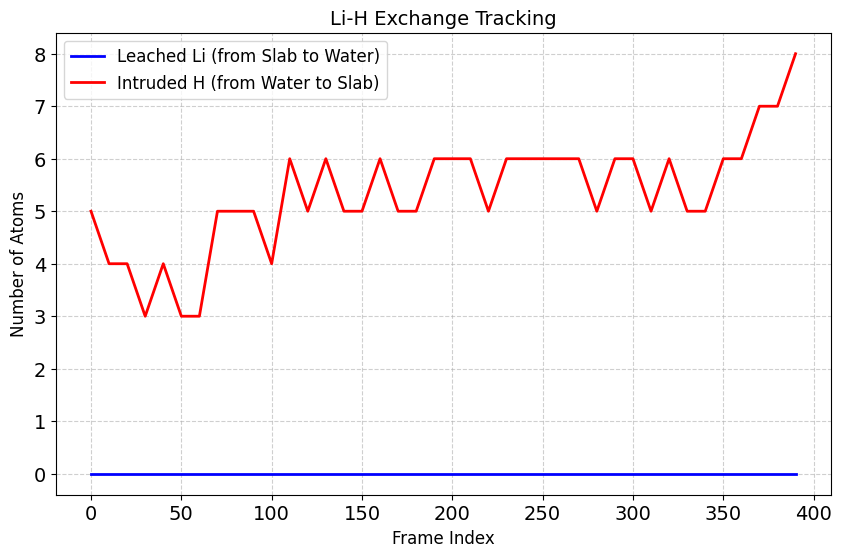

Analysis complete. Results saved to /home/jovyan/Kaori/MD/LiB_2/structure/md_ramp_results/nmc_h2o_md_400K.png
⚠️ Possible ion exchange detected!
Reading trajectory: /home/jovyan/Kaori/MD/LiB_2/structure/md_ramp_results/nmc_h2o_md_500K.traj
Analyzing Li-H exchange indicators frame by frame...


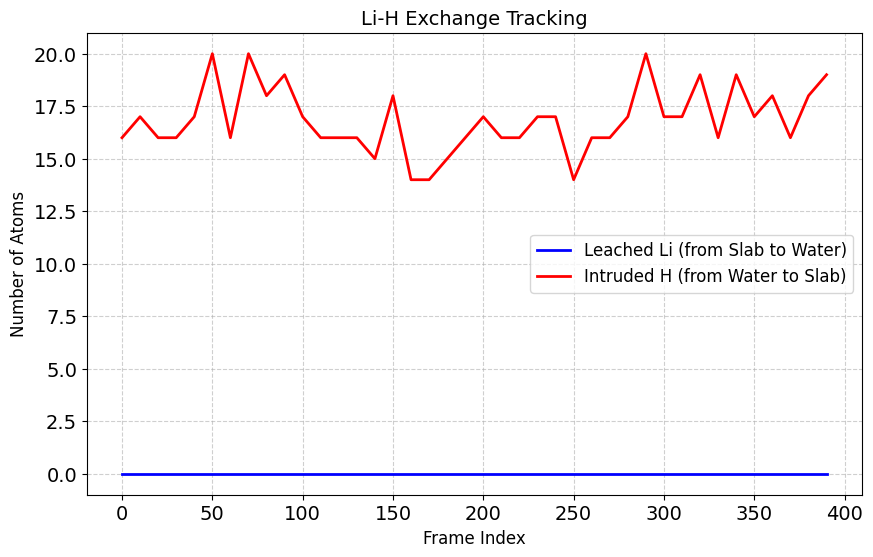

Analysis complete. Results saved to /home/jovyan/Kaori/MD/LiB_2/structure/md_ramp_results/nmc_h2o_md_500K.png
⚠️ Possible ion exchange detected!
Reading trajectory: /home/jovyan/Kaori/MD/LiB_2/structure/md_ramp_results/nmc_h2o_md_600K.traj
Analyzing Li-H exchange indicators frame by frame...


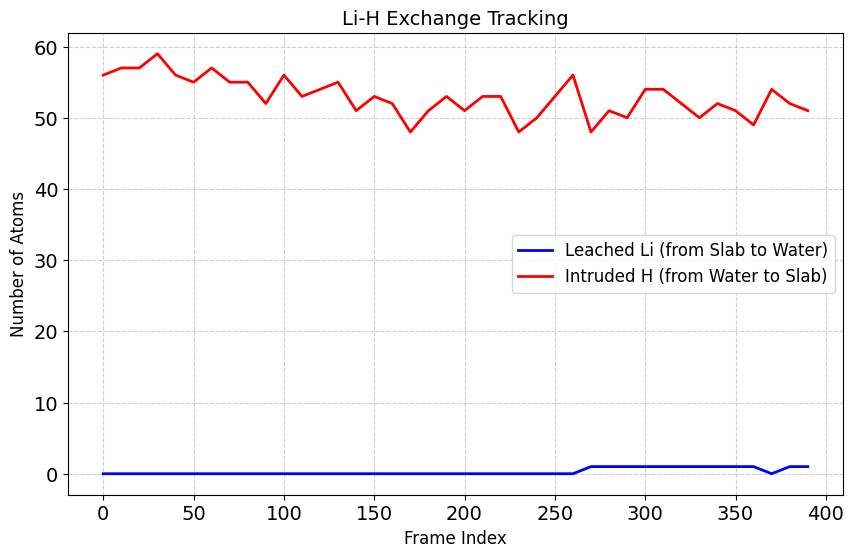

Analysis complete. Results saved to /home/jovyan/Kaori/MD/LiB_2/structure/md_ramp_results/nmc_h2o_md_600K.png
⚠️ Possible ion exchange detected!


In [7]:
import numpy as np
import matplotlib.pyplot as plt
from ase.io import read
from ase.geometry.analysis import Analysis
def analyze_exchange_possibility(traj_path, output_dir="analysis_results",save_path="li_h_exchange_analysis.png"):
    output_dir = Path(output_dir)
    output_dir.mkdir(exist_ok=True)
    
    print(f"Reading trajectory: {traj_path}")
    traj = read(traj_path, index=':')
    
    # 1. 原子の分類 (最初のフレームで判定)
    first_frame = traj[0]
    symbols = np.array(first_frame.get_chemical_symbols())
    positions = first_frame.get_positions()
    
    # スラブ(NMC)領域の定義 (Z=15AからZ=pos_maxの間にあるLi)
    nmc_li_indices = [i for i, (s, p) in enumerate(zip(symbols, positions)) 
                      if s == 'Li' and 15.0 <= p[2] <= (positions[:,2].max() - 15.0)]
    
    # 全てのH原子のインデックス
    h_indices = [i for i, s in enumerate(symbols) if s == 'H']
    
    # スラブ境界の定義
    slab_z_min = 15.0
    slab_z_max = positions[:, 2].max() - 15.0

    li_leached_count = []  # スラブ外に出たLiの数
    h_intruded_count = []  # スラブ内に侵入したHの数
    time_steps = []

    print("Analyzing Li-H exchange indicators frame by frame...")
    for frame_idx, atoms in enumerate(traj[::10]): # 10フレームおき
        pos = atoms.get_positions()
        
        # --- Li溶出の判定 ---
        # スラブ領域(15.0 < z < slab_z_max)の外に出たLiをカウント
        current_li_z = pos[nmc_li_indices, 2]
        leached = np.sum((current_li_z < slab_z_min - 1.0) | (current_li_z > slab_z_max + 1.0))
        li_leached_count.append(leached)
        
        # --- H侵入の判定 ---
        # スラブ領域(15.0 < z < slab_z_max)の内側に入ったHをカウント
        current_h_z = pos[h_indices, 2]
        intruded = np.sum((current_h_z >=( slab_z_min+1.0)) & (current_h_z <=( slab_z_max-1.0)))
        h_intruded_count.append(intruded)
        
        time_steps.append(frame_idx * 10)

    # --- 可視化 ---
    plt.figure(figsize=(10, 6))
    plt.plot(time_steps, li_leached_count, label='Leached Li (from Slab to Water)', color='blue', lw=2)
    plt.plot(time_steps, h_intruded_count, label='Intruded H (from Water to Slab)', color='red', lw=2)
    
    plt.title('Li-H Exchange Tracking', fontsize=14)
    plt.xlabel('Frame Index', fontsize=12)
    plt.ylabel('Number of Atoms', fontsize=12)
    plt.grid(True, linestyle='--', alpha=0.6)
    plt.legend()
    
    save_path =save_path
    # output_dir / "li_h_exchange_analysis.png"
    plt.savefig(save_path)
    plt.show()
    
    print(f"Analysis complete. Results saved to {save_path}")
    if max(li_leached_count) > 0 or max(h_intruded_count) > 0:
        print("⚠️ Possible ion exchange detected!")
    else:
        print("ℹ️ No ion exchange detected in this trajectory.")

# analyze_exchange_possibility("md_results/nmc_h2o_md.traj")
def analyze_md_results(traj_path, output_dir="analysis_results"):
    output_dir = Path(output_dir)
    output_dir.mkdir(exist_ok=True)
    
    # 1. 軌跡の読み込み (後半50%を解析対象とする)
    print(f"Loading trajectory: {traj_path}")
    traj = read(traj_path, index=':')
    n_frames = len(traj)
    start_idx = n_frames // 2  # 平衡状態に達したと思われる後半のみ抽出
    frames = traj[start_idx:]
    print(f"Analyzing {len(frames)} frames (from index {start_idx} to {n_frames})")

    # --- 解析1: Z-Density Profile (水分子のZ軸方向分布) ---
    z_coords = []
    cell_z = frames[0].cell[2,2]
    
    for atoms in frames:
        # 水分子（酸素原子）のZ座標を取得
        water_z = [a.position[2] for a in atoms if a.symbol == 'O' and 
                   atoms.get_chemical_symbols().count('O') > 10] # NMCの酸素と区別する簡易フィルタ
        # ※ より正確には、原子インデックスで指定するのが確実です
        z_coords.extend(water_z)

    plt.figure(figsize=(8, 5))
    plt.hist(z_coords, bins=200, density=True, alpha=0.7, color='skyblue', edgecolor='navy')
    plt.axvspan(15.0, cell_z-15.0, color='gray', alpha=0.3, label='NMC Slab') # NMCの領域を可視化
    plt.xlabel('Z coordinate (Å)')
    plt.ylabel('Density (arb. unit)')
    plt.title('Z-Density Profile of Water')
    plt.legend()
    plt.grid(axis='y', linestyle='--', alpha=0.6)
    plt.savefig(output_dir / "z_density_profile.png")
    plt.show()

    # --- 解析2: Radial Distribution Function (RDF) ---
    # 例: NMC表面付近のLi原子と、水の酸素(O)の相関
    print("Calculating RDF (Li - O_water)...")
    # 簡易的に全原子を対象にする例（特定が必要な場合はindicesを指定）
    ana = Analysis(frames)
    rdf = ana.get_rdf(rmax=8.0, nbins=100, elements=['Li', 'O'])
    
    # get_rdfの結果はリスト形式なので平均をとる
    rdf_avg = np.mean(rdf, axis=0)
    r = np.linspace(0, 8.0, 100)

    plt.figure(figsize=(8, 5))
    plt.plot(r, rdf_avg, color='crimson', lw=2)
    plt.xlabel('Distance r (Å)')
    plt.ylabel('g(r)')
    plt.title('RDF: Li (Slab) - O (Water)')
    plt.grid(linestyle='--', alpha=0.6)
    plt.savefig(output_dir / "rdf_li_o.png")
    plt.show()

    print(f"Analysis plots saved to {output_dir}")

# --- 実行 ---
# traj_list =[ "md_results/nmc_h2o_md.traj"
temps=[400,500,600]
for temp in temps:
    traj_path=f"/home/jovyan/Kaori/MD/LiB_2/structure/md_ramp_results/nmc_h2o_md_{temp}K.traj"
    save_path=f"/home/jovyan/Kaori/MD/LiB_2/structure/md_ramp_results/nmc_h2o_md_{temp}K.png"
    # Kaori/MD/LiB_2/structure/md_ramp_results/nmc_h2o_md_400K.traj
    analyze_exchange_possibility(traj_path,save_path=save_path)



In [13]:
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path
from ase.io import read

def analyze_dynamic_depth_with_surface_mark(traj_path, output_dir="analysis_results", slab_margin=15.0):
    """
    H原子の侵入深さに加え、NMC表面（TM骨格）の分布も可視化して、
    「表面位置」を明確にしたヒストグラムを作成する。
    """
    traj_path = Path(traj_path)
    output_dir = Path(output_dir)
    output_dir.mkdir(parents=True, exist_ok=True)
    
    print(f"--- Loading Trajectory: {traj_path.name} ---")
    try:
        traj = read(traj_path, index=':')
    except Exception as e:
        print(f"Error reading file {traj_path}: {e}")
        return

    if not traj:
        print("Error: Trajectory is empty.")
        return

    # --- A. インデックス特定 ---
    first_frame = traj[0]
    pos_0 = first_frame.get_positions()
    symbols = np.array(first_frame.get_chemical_symbols())
    z_max_total = first_frame.cell.lengths()[2]
    
    # 1. 遷移金属 (TM) - 表面の基準
    tm_indices = [i for i, s in enumerate(symbols) if s in ['Ni', 'Mn', 'Co']]
    if not tm_indices:
        # TMがない場合は酸素を代用（テスト用）
        tm_indices = [i for i, s in enumerate(symbols) if s == 'O' and (slab_margin < pos_0[i, 2] < z_max_total - slab_margin)]

    # 2. H原子 - 追跡対象
    h_indices = [i for i, s in enumerate(symbols) if s == 'H']

    # --- B. フレーム毎の深さ計算 ---
    h_depths_final = []
    tm_depths_final = []  # TM原子の分布用
    
    print("Analyzing depth profiles...")
    
    # 後半50%のフレームのみを対象（平衡状態を見るため）
    start_frame = len(traj) // 2
    
    for step, atoms in enumerate(traj[start_frame:], start=start_frame):
        pos = atoms.get_positions()
        
        # 1. その瞬間の表面位置 (TM最外層)
        tm_z = pos[tm_indices, 2]
        current_surf_top = np.max(tm_z)
        
        # 2. H原子の深さ (Topからの距離)
        # Depth = Surface - z (正の値ほど内部)
        h_z = pos[h_indices, 2]
        h_dist = current_surf_top - h_z
        
        # 「表面より下」かつ「スラブ中心付近まで」のHを抽出
        # (スラブの厚みの半分程度までを対象とする簡易フィルタ)
        slab_thickness = np.max(tm_z) - np.min(tm_z)
        valid_h = h_dist[(h_dist > -2.0) & (h_dist < slab_thickness / 2)] 
        # ※ -2.0まで含めることで、表面に浮いているHも少し表示させる
        
        h_depths_final.extend(valid_h)
        
        # 3. TM原子自体の深さ分布も計算 (表面ラフネスの可視化用)
        # 最外層TMは常に0になるが、第2層、第3層のTMがどこに来るかを見る
        tm_dist = current_surf_top - tm_z
        valid_tm = tm_dist[tm_dist < slab_thickness / 2]
        tm_depths_final.extend(valid_tm)

    # --- C. ヒストグラム作成 (修正版) ---
    if h_depths_final:
        plt.figure(figsize=(9, 6))
        
        # 1. TM骨格の分布 (グレー背景)
        # これにより「ここまでがNMCの固体部分」ということがわかる
        plt.hist(tm_depths_final, bins=50, density=True, color='gray', alpha=0.3, label='NMC Skeleton (TMs)')
        
        # 2. H侵入の分布 (赤色)
        plt.hist(h_depths_final, bins=50, density=True, color='red', alpha=0.6, label='Intruded Hydrogen')
        
        # 3. 表面位置の強調 (x=0)
        plt.axvline(x=0, color='black', linestyle='-', linewidth=2, label='Surface (Outermost TM)')
        
        # 補助線とラベル
        plt.axvline(x=2.0, color='black', linestyle=':', alpha=0.5)
        plt.text(2.1, plt.ylim()[1]*0.9, 'Deep Intrusion region', fontsize=9, color='darkred')
        plt.text(-0.5, plt.ylim()[1]*0.9, 'Outside', fontsize=9, ha='right')
        
        plt.xlabel('Depth from Outermost Surface ($\AA$)\n(Positive = Inside Slab, Negative = Outside)')
        plt.ylabel('Normalized Frequency')
        plt.title(f'Depth Profile: H Intrusion vs NMC Surface\n({traj_path.name})')
        plt.legend(loc='upper right')
        plt.grid(True, alpha=0.3)
        plt.xlim(-5, 15)  # 表示範囲の調整 (表面付近にフォーカス)
        
        save_path = output_dir / f"{traj_path.stem}_depth_with_surface.png"
        plt.savefig(save_path)
        plt.close()
        print(f"Plot saved to {save_path}")
    else:
        print("No valid H atoms found for histogram.")

# --- 実行ブロック ---
if __name__ == "__main__":
    # パスの設定
    base_dir = Path("/home/jovyan/Kaori/MD/LiB_2/structure/md_ramp_results")
    output_base = base_dir / "analysis_plots_surface_vis"
    
    # 実行対象
    temperatures = [400,500,600] # 確認したい温度
    
    for temp in temperatures:
        traj_file = base_dir / f"nmc_h2o_md_{temp}K.traj"
        if traj_file.exists():
            analyze_dynamic_depth_with_surface_mark(str(traj_file), str(output_base))
        else:
            print(f"Skipping {temp}K...")

--- Loading Trajectory: nmc_h2o_md_400K.traj ---
Analyzing depth profiles...
Plot saved to /home/jovyan/Kaori/MD/LiB_2/structure/md_ramp_results/analysis_plots_surface_vis/nmc_h2o_md_400K_depth_with_surface.png
--- Loading Trajectory: nmc_h2o_md_500K.traj ---
Analyzing depth profiles...
Plot saved to /home/jovyan/Kaori/MD/LiB_2/structure/md_ramp_results/analysis_plots_surface_vis/nmc_h2o_md_500K_depth_with_surface.png
--- Loading Trajectory: nmc_h2o_md_600K.traj ---
Analyzing depth profiles...
Plot saved to /home/jovyan/Kaori/MD/LiB_2/structure/md_ramp_results/analysis_plots_surface_vis/nmc_h2o_md_600K_depth_with_surface.png


In [14]:
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path
from ase.io import read

def analyze_sandwich_depth_profile(traj_path, output_dir="analysis_results", slab_margin=15.0):
    """
    サンドイッチ構造(水-NMC-水)の上下両方の界面を考慮し、
    「表面からの深さ」を統合してヒストグラムを作成する。
    """
    traj_path = Path(traj_path)
    output_dir = Path(output_dir)
    output_dir.mkdir(parents=True, exist_ok=True)
    
    print(f"--- Loading Trajectory: {traj_path.name} ---")
    try:
        traj = read(traj_path, index=':')
    except Exception as e:
        print(f"Error reading file {traj_path}: {e}")
        return

    if not traj:
        print("Error: Trajectory is empty.")
        return

    # --- A. インデックス特定 ---
    first_frame = traj[0]
    pos_0 = first_frame.get_positions()
    symbols = np.array(first_frame.get_chemical_symbols())
    z_max_total = first_frame.cell.lengths()[2]
    
    # TM (Ni, Mn, Co)
    tm_indices = [i for i, s in enumerate(symbols) if s in ['Ni', 'Mn', 'Co']]
    if not tm_indices:
        tm_indices = [i for i, s in enumerate(symbols) if s == 'O' and (slab_margin < pos_0[i, 2] < z_max_total - slab_margin)]

    # H原子
    h_indices = [i for i, s in enumerate(symbols) if s == 'H']

    # --- B. フレーム毎の深さ計算 (上下統合) ---
    combined_h_depths = []
    combined_tm_depths = []
    
    print("Analyzing dual-interface depth profiles...")
    start_frame = len(traj) // 2
    
    for step, atoms in enumerate(traj[start_frame:], start=start_frame):
        pos = atoms.get_positions()
        
        # 1. 表面位置の特定 (Top と Bottom)
        tm_z = pos[tm_indices, 2]
        surf_top = np.max(tm_z)
        surf_btm = np.min(tm_z)
        slab_center = (surf_top + surf_btm) / 2.0
        
        # 2. H原子の深さ計算 (近い方の表面を基準にする)
        h_z = pos[h_indices, 2]
        
        # 深さの定義: 
        #   Upper側 (z > center): Depth = Top - z
        #   Lower側 (z < center): Depth = z - Bottom
        #   (どちらも「正の値」がスラブ内部、「負の値」が水側になる)
        
        # 上半分にあるHの深さ
        h_depths_upper = surf_top - h_z[h_z >= slab_center]
        
        # 下半分にあるHの深さ
        h_depths_lower = h_z[h_z < slab_center] - surf_btm
        
        # データを結合
        combined_h_depths.extend(h_depths_upper)
        combined_h_depths.extend(h_depths_lower)
        
        # 3. TM原子自体の深さ分布 (表面ラフネス確認用) も同様に計算
        # 第1層(0付近), 第2層, ... のピーク確認用
        tm_depths_upper = surf_top - tm_z[tm_z >= slab_center]
        tm_depths_lower = tm_z[tm_z < slab_center] - surf_btm
        
        combined_tm_depths.extend(tm_depths_upper)
        combined_tm_depths.extend(tm_depths_lower)

    # --- C. ヒストグラム作成 ---
    if combined_h_depths:
        plt.figure(figsize=(9, 6))
        
        # 1. TM骨格分布 (グレー) - 上下界面のデータを合算
        plt.hist(combined_tm_depths, bins=60, density=True, color='gray', alpha=0.3, label='NMC Skeleton (TMs)')
        
        # 2. H侵入分布 (赤色) - 上下界面のデータを合算
        # 範囲を -5A (水側) から 10A (内部) 程度に絞る
        plt.hist(combined_h_depths, bins=60, range=(-5, 10), density=True, color='red', alpha=0.6, label='Intruded Hydrogen')
        
        # 3. 表面位置 (x=0)
        plt.axvline(x=0, color='black', linestyle='-', linewidth=2, label='Surface (Outermost TM)')
        
        # 補助線
        plt.axvline(x=2.0, color='black', linestyle=':', alpha=0.5)
        plt.text(2.1, plt.ylim()[1]*0.9, 'Deep Intrusion', fontsize=9, color='darkred')
        plt.text(-0.5, plt.ylim()[1]*0.9, 'Water Region', fontsize=9, ha='right')
        
        plt.xlabel('Depth from Nearest Surface ($\AA$)\n(Positive = Inside Slab, Negative = Outside)')
        plt.ylabel('Normalized Frequency (Top & Bottom Combined)')
        plt.title(f'Dual-Interface Depth Profile: {traj_path.name}')
        plt.legend(loc='upper right')
        plt.grid(True, alpha=0.3)
        plt.xlim(-5, 10)
        
        save_path = output_dir / f"{traj_path.stem}_sandwich_depth.png"
        plt.savefig(save_path)
        plt.close()
        print(f"Plot saved to {save_path}")
    else:
        print("No valid H atoms found.")

# --- 実行ブロック ---
if __name__ == "__main__":
    base_dir = Path("/home/jovyan/Kaori/MD/LiB_2/structure/md_ramp_results")
    output_base = base_dir / "analysis_plots_sandwich"
    
    temp = 600
    traj_file = base_dir / f"nmc_h2o_md_{temp}K.traj"
    if traj_file.exists():
        analyze_sandwich_depth_profile(str(traj_file), str(output_base))

--- Loading Trajectory: nmc_h2o_md_600K.traj ---
Analyzing dual-interface depth profiles...
Plot saved to /home/jovyan/Kaori/MD/LiB_2/structure/md_ramp_results/analysis_plots_sandwich/nmc_h2o_md_600K_sandwich_depth.png


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path
from ase.io import read
from ase.geometry.analysis import Analysis

def analyze_dynamic_surface_depth(traj_path, output_dir="analysis_results", slab_margin=15.0):
    """
    遷移金属(Ni, Mn, Co)の位置から動的に表面位置を特定し、
    そこからの相対深さに基づいてLi溶出・H侵入を解析する。
    """
    traj_path = Path(traj_path)
    output_dir = Path(output_dir)
    output_dir.mkdir(parents=True, exist_ok=True)
    
    print(f"--- Loading Trajectory: {traj_path.name} ---")
    try:
        traj = read(traj_path, index=':')
    except Exception as e:
        print(f"Error reading file {traj_path}: {e}")
        return

    if not traj:
        print("Error: Trajectory is empty.")
        return

    # --- A. インデックスの特定 (初期フレームのみ使用) ---
    first_frame = traj[0]
    pos_0 = first_frame.get_positions()
    symbols = np.array(first_frame.get_chemical_symbols())
    cell_lengths = first_frame.cell.lengths()
    z_max_total = cell_lengths[2]
    
    # 1. 遷移金属 (TM: Skeleton) - 表面位置の基準
    # Ni, Mn, Co のインデックスを取得
    tm_indices = [
        i for i, s in enumerate(symbols) 
        if s in ['Ni', 'Mn', 'Co']
    ]
    
    # もしTMがない場合（テスト用などでLi, Oのみの場合）は、NMC領域のOを使うなどのフォールバックが必要
    if not tm_indices:
        print("Warning: No Ni/Mn/Co found. Using Slab Oxygen as skeleton reference.")
        tm_indices = [
            i for i, s in enumerate(symbols)
            if s == 'O' and (slab_margin < pos_0[i, 2] < z_max_total - slab_margin)
        ]

    # 2. NMC Lithium - 追跡対象
    nmc_li_indices = [
        i for i, s in enumerate(symbols) 
        if s == 'Li' and (slab_margin <= pos_0[i, 2] <= z_max_total - slab_margin)
    ]
    
    # 3. Water Hydrogen - 追跡対象
    h_indices = [i for i, s in enumerate(symbols) if s == 'H']
    
    # 4. Water Oxygen - 参考用
    water_o_indices = [
        i for i, s in enumerate(symbols) 
        if s == 'O' and (pos_0[i, 2] < slab_margin or pos_0[i, 2] > z_max_total - slab_margin)
    ]

    print(f"  - Skeleton Atoms (TM): {len(tm_indices)}")
    print(f"  - NMC Li: {len(nmc_li_indices)}")
    
    # --- B. フレームごとの解析 ---
    li_leached_counts = []
    h_intruded_counts = []
    
    # 深さヒストグラム用のリスト (後半フレームのみ蓄積)
    li_depths_final = []
    h_depths_final = []
    
    print("Running frame-by-frame analysis with DYNAMIC surface calculation...")
    
    for step, atoms in enumerate(traj):
        pos = atoms.get_positions()
        
        # 1. その瞬間の表面位置を計算 (TM原子の最外層)
        # 上面(Top)と下面(Bottom)を特定
        tm_z = pos[tm_indices, 2]
        current_surf_top = np.max(tm_z)
        current_surf_btm = np.min(tm_z)
        
        # 2. Liの溶出判定 (動的表面に基づく)
        # 表面よりも "外側" にあるLiをカウント
        # バッファ +1.0A (表面の凹凸や吸着状態を考慮)
        current_li_z = pos[nmc_li_indices, 2]
        
        # Topより上 または Bottomより下
        is_leached = (current_li_z > current_surf_top + 1.0) | \
                     (current_li_z < current_surf_btm - 1.0)
        li_leached_counts.append(np.sum(is_leached))
        
        # 3. Hの侵入判定
        # 表面よりも "内側" に深く入ったHをカウント
        # 表面吸着(約1.0A)を除外するため、+2.0A 程度深く設定
        current_h_z = pos[h_indices, 2]
        is_intruded = (current_h_z < current_surf_top - 2.0) & \
                      (current_h_z > current_surf_btm + 2.0)
        h_intruded_counts.append(np.sum(is_intruded))

        # 4. 深さ分布の計算 (後半のフレームのみ)
        if step > len(traj) // 2:
            # Hの深さ (表面からの距離)
            # Top側からの距離: Top - z (正なら内部)
            # Bottom側からの距離: z - Bottom (正なら内部)
            # どちらか近い方の表面からの距離を採用する
            dist_from_top = current_surf_top - current_h_z
            dist_from_btm = current_h_z - current_surf_btm
            
            # スラブ内部にあるHの深さを記録 (表面より内側にあるもののみ)
            # ここでは「表面より下」かつ「中心より上」のような単純化でTop側侵入を見る
            # もしくは単純に「正の値」を持つものを侵入深度とする
            
            # Top表面からの深さ（Topより下にあるHについて）
            valid_h_top = dist_from_top[(dist_from_top > 0) & (dist_from_top < (current_surf_top - current_surf_btm))]
            h_depths_final.extend(valid_h_top)

    # --- C. プロット ---
    
    # 1. 時系列: 溶出と侵入
    plt.figure(figsize=(10, 6))
    time_axis = np.arange(len(traj))
    plt.plot(time_axis, li_leached_counts, label='Leached Li (Out of TM skeleton)', color='blue', alpha=0.8)
    plt.plot(time_axis, h_intruded_counts, label='Intruded H (Deep inside TM skeleton)', color='red', alpha=0.8)
    plt.xlabel('Time Step')
    plt.ylabel('Count of Atoms')
    plt.title(f'Dynamic Surface Analysis: {traj_path.name}')
    plt.legend()
    plt.grid(True, linestyle='--', alpha=0.6)
    plt.savefig(output_dir / f"{traj_path.stem}_dynamic_exchange.png")
    plt.close()

    # 2. Hの侵入深さ分布 (ヒストグラム)
    if h_depths_final:
        plt.figure(figsize=(8, 5))
        plt.hist(h_depths_final, bins=50, color='red', alpha=0.6, label='H Depth from Surface')
        plt.xlabel('Depth from Outermost TM Layer ($\AA$)')
        plt.ylabel('Frequency')
        plt.title(f'H Intrusion Depth Profile: {traj_path.name}')
        plt.legend()
        plt.grid(True, alpha=0.3)
        plt.savefig(output_dir / f"{traj_path.stem}_h_depth_hist.png")
        plt.close()
    
    print(f"Analysis completed. Saved to {output_dir}")

# --- 実行ブロック ---
if __name__ == "__main__":
    base_dir = Path("/home/jovyan/Kaori/MD/LiB_2/structure/md_ramp_results")
    output_base = base_dir / "analysis_plots_dynamic"
    
    # 例として600Kのみ実行、必要に応じてループ可
    temperatures = [400, 500, 600, 750, 900]
    for temp in temperatures:
        traj_file = base_dir / f"nmc_h2o_md_{temp}K.traj"
        if traj_file.exists():
            analyze_dynamic_surface_depth(str(traj_file), str(output_base))

In [10]:
import numpy as np
import matplotlib.pyplot as plt
import os
from pathlib import Path
from ase.io import read
from ase.geometry.analysis import Analysis

# --- Main Analysis Function ---
def analyze_trajectory_refined(traj_path, output_dir="analysis_results", slab_margin=15.0):
    """
    Analyzes MD trajectory to visualize Li leaching, H intrusion, MSD, and RDF.
    
    Args:
        traj_path (str): Path to the .traj or .xyz file
        output_dir (str): Directory to save results
        slab_margin (float): Estimated thickness of water layer on top/bottom (Angstrom)
                             Used for initial classification of atoms.
    """
    traj_path = Path(traj_path)
    output_dir = Path(output_dir)
    output_dir.mkdir(parents=True, exist_ok=True)
    
    print(f"--- Loading Trajectory: {traj_path.name} ---")
    
    # Read trajectory
    try:
        traj = read(traj_path, index=':')
    except Exception as e:
        print(f"Error reading file {traj_path}: {e}")
        return

    if not traj:
        print("Error: Trajectory is empty.")
        return

    # --- A. Initial Setup & Index Identification ---
    # Use the first frame to identify which atoms are which based on initial positions
    first_frame = traj[0]
    pos_0 = first_frame.get_positions()
    symbols = np.array(first_frame.get_chemical_symbols())
    
    # Get cell dimensions to fix "CellTooSmall" error
    cell_lengths = first_frame.cell.lengths()
    z_max_total = cell_lengths[2]
    min_cell_length = min(cell_lengths)
    
    print(f"  - Cell dimensions: {cell_lengths}")
    
    # Define Slab Region (Z-axis)
    # Assumes structure is: [Water] -- [NMC Slab] -- [Water]
    slab_z_lower = slab_margin
    slab_z_upper = z_max_total - slab_margin
    
    # Identify Indices
    # 1. Water Oxygen: O atoms initially OUTSIDE the slab region
    water_o_indices = [
        i for i, s in enumerate(symbols) 
        if s == 'O' and (pos_0[i, 2] < slab_z_lower or pos_0[i, 2] > slab_z_upper)
    ]
    
    # 2. NMC Lithium: Li atoms initially INSIDE the slab region
    nmc_li_indices = [
        i for i, s in enumerate(symbols) 
        if s == 'Li' and (slab_z_lower <= pos_0[i, 2] <= slab_z_upper)
    ]
    
    # 3. All Hydrogen atoms
    h_indices = [i for i, s in enumerate(symbols) if s == 'H']

    print(f"  - Water Oxygen count: {len(water_o_indices)}")
    print(f"  - NMC Li count: {len(nmc_li_indices)}")
    print(f"  - Total Frames: {len(traj)}")

    # --- B. Time-Series Data Extraction ---
    li_leached_counts = []
    h_intruded_counts = []
    water_o_z_dist = []  # For density profile
    li_displacements = [] # For MSD
    
    print("Running frame-by-frame analysis...")
    
    for step, atoms in enumerate(traj):
        pos = atoms.get_positions()
        
        # 1. Li Leaching Count
        # Count Li atoms that have moved OUT of the initial slab region (with buffer)
        current_li_z = pos[nmc_li_indices, 2]
        is_leached = (current_li_z < slab_z_lower - 2.0) | (current_li_z > slab_z_upper + 2.0)
        li_leached_counts.append(np.sum(is_leached))
        
        # 2. H Intrusion Count
        # Count H atoms that have moved DEEP INTO the slab region
        current_h_z = pos[h_indices, 2]
        is_intruded = (current_h_z > slab_z_lower + 2.0) & (current_h_z < slab_z_upper - 2.0)
        h_intruded_counts.append(np.sum(is_intruded))
        
        # 3. Collect Water Z-coords for Density Profile (Use only last 50% of frames)
        if step > len(traj) // 2:
            water_o_z_dist.extend(pos[water_o_indices, 2])
            
        # 4. Li MSD (Mean Squared Displacement) Calculation
        # Simple MSD relative to t=0 position.
        diff = pos[nmc_li_indices] - pos_0[nmc_li_indices]
        
        # Simple PBC correction for distance calculation
        diff = diff - np.round(diff / cell_lengths) * cell_lengths
        
        # Mean squared distance for all Li atoms
        msd_frame = np.mean(np.sum(diff**2, axis=1))
        li_displacements.append(msd_frame)

    # --- C. RDF (Radial Distribution Function) Calculation ---
    print("Calculating Specific RDF (Li_slab - O_water)...")
    
    # [FIX] Automatically adjust rmax to fit cell size
    # Must be less than half of the smallest cell dimension
    safe_rmax = min(5.5, min_cell_length / 2.0 - 0.1) 
    print(f"  - Setting rmax to {safe_rmax:.2f} A (Cell min dim: {min_cell_length:.2f} A)")
    
    rdf_r = np.linspace(0, safe_rmax, 80)
    rdf_g = np.zeros_like(rdf_r)
    
    # Analyze every 10th frame from the second half
    rdf_frames = traj[len(traj)//2::10] 
    
    count_frames = 0
    if len(rdf_frames) > 0:
        for atoms in rdf_frames:
            # Create a temporary subset with ONLY NMC-Li and Water-O
            # This isolates the solvation signal we care about
            target_indices = nmc_li_indices + water_o_indices
            subset_atoms = atoms[target_indices]
            
            # Use ASE Analysis class
            ana = Analysis([subset_atoms])
            # Calculate RDF between all Li and O in this subset
            rdf_tmp = ana.get_rdf(rmax=safe_rmax, nbins=80, elements=['Li', 'O'])[0]
            rdf_g += rdf_tmp
            count_frames += 1
            
        if count_frames > 0:
            rdf_g /= count_frames
    else:
        print("Warning: Not enough frames for RDF analysis.")

    # --- D. Plotting & Saving ---
    
    # 1. Ion Exchange Plot (Li Leaching & H Intrusion)
    plt.figure(figsize=(10, 6))
    time_axis = np.arange(len(traj))
    plt.plot(time_axis, li_leached_counts, label='Leached Li ($Li^+$ out)', color='blue', alpha=0.8, linewidth=2)
    plt.plot(time_axis, h_intruded_counts, label='Intruded H ($H^+$ in)', color='red', alpha=0.8, linewidth=2)
    plt.xlabel('Time Step')
    plt.ylabel('Number of Atoms')
    plt.title(f'Ion Exchange Dynamics: {traj_path.name}')
    plt.legend()
    plt.grid(True, linestyle='--', alpha=0.6)
    plt.savefig(output_dir / f"{traj_path.stem}_exchange.png")
    plt.close()

    # 2. Li MSD Plot
    plt.figure(figsize=(10, 6))
    plt.plot(time_axis, li_displacements, color='green', linewidth=2)
    plt.xlabel('Time Step')
    plt.ylabel('Mean Squared Displacement ($\AA^2$)')
    plt.title(f'MSD of NMC Lithium: {traj_path.name}')
    plt.grid(True, linestyle='--', alpha=0.6)
    plt.savefig(output_dir / f"{traj_path.stem}_li_msd.png")
    plt.close()

    # 3. Water Density Profile
    if water_o_z_dist:
        plt.figure(figsize=(8, 5))
        plt.hist(water_o_z_dist, bins=100, density=True, color='skyblue', alpha=0.7, label='Water Oxygen')
        plt.axvspan(slab_z_lower, slab_z_upper, color='gray', alpha=0.2, label='Initial NMC Region')
        plt.xlabel('Z Coordinate ($\AA$)')
        plt.ylabel('Density (arb. units)')
        plt.title(f'Water Z-Distribution: {traj_path.name}')
        plt.legend()
        plt.savefig(output_dir / f"{traj_path.stem}_density.png")
        plt.close()

    # 4. RDF Plot
    plt.figure(figsize=(8, 5))
    plt.plot(rdf_r, rdf_g, color='crimson', lw=2)
    plt.xlabel('Distance ($\AA$)')
    plt.ylabel('g(r)')
    plt.title(f'RDF: NMC Li - Water Oxygen ({traj_path.name})\n(Solvation Structure)')
    plt.grid(True, linestyle='--', alpha=0.6)
    plt.xlim(0, safe_rmax)
    plt.savefig(output_dir / f"{traj_path.stem}_rdf.png")
    plt.close()

    print(f"Results saved to: {output_dir}")
    print("-" * 30)

# --- Execution Block ---
if __name__ == "__main__":
    # Define your base path and temperatures here
    # Please update the path to match your actual directory structure
    base_dir = Path("/home/jovyan/Kaori/MD/LiB_2/structure/md_ramp_results")
    output_base = base_dir / "analysis_plots_refined"
    
    # Process multiple temperatures
    temperatures = [300, 400, 500, 600, 750, 900]
    
    for temp in temperatures:
        traj_file = base_dir / f"nmc_h2o_md_{temp}K.traj"
        
        if traj_file.exists():
            try:
                analyze_trajectory_refined(
                    traj_path=str(traj_file),
                    output_dir=str(output_base),
                    slab_margin=15.0  # Adjust based on your Packmol water layer settings
                )
            except Exception as e:
                print(f"Error analyzing {temp}K: {e}")
        else:
            print(f"Sｓぁkipping {temp}K: File not found ({traj_file})")

Skipping 300K: File not found (/home/jovyan/Kaori/MD/LiB_2/structure/md_ramp_results/nmc_h2o_md_300K.traj)
--- Loading Trajectory: nmc_h2o_md_400K.traj ---
  - Cell dimensions: [11.76094577 12.45       54.97686848]
  - Water Oxygen count: 181
  - NMC Li count: 100
  - Total Frames: 400
Running frame-by-frame analysis...
Calculating Specific RDF (Li_slab - O_water)...
  - Setting rmax to 5.50 A (Cell min dim: 11.76 A)
Results saved to: /home/jovyan/Kaori/MD/LiB_2/structure/md_ramp_results/analysis_plots_refined
------------------------------
--- Loading Trajectory: nmc_h2o_md_500K.traj ---
  - Cell dimensions: [11.76094577 12.45       54.97686848]
  - Water Oxygen count: 181
  - NMC Li count: 101
  - Total Frames: 400
Running frame-by-frame analysis...
Calculating Specific RDF (Li_slab - O_water)...
  - Setting rmax to 5.50 A (Cell min dim: 11.76 A)
Results saved to: /home/jovyan/Kaori/MD/LiB_2/structure/md_ramp_results/analysis_plots_refined
------------------------------
--- Loading T